In [211]:
import pandas as pd  
import numpy as np 
import datetime as dt 
from pandas_datareader import data as pdr
import yfinance as yfin
from prophet import Prophet
from prophet.plot import (
    plot_plotly,
    plot_components_plotly,
    plot_forecast_component_plotly,
    plot_seasonality_plotly
)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots

import talib as ta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [212]:
yfin.pdr_override()

data = pdr.get_data_yahoo('AAPL',  start='2018-12-31' )
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,39.632500,39.840000,39.119999,39.435001,37.900017,140014000
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.943256,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.163826,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.622253,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.542961,219111200
...,...,...,...,...,...,...
2023-10-10,178.100006,179.720001,177.949997,178.389999,178.389999,43698000
2023-10-11,178.199997,179.850006,177.600006,179.800003,179.800003,47551100
2023-10-12,180.070007,182.339996,179.039993,180.710007,180.710007,56743100


In [143]:
d2 = data.reset_index().rename(columns = {'Date':'ds', 'Close':'y'})

20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing


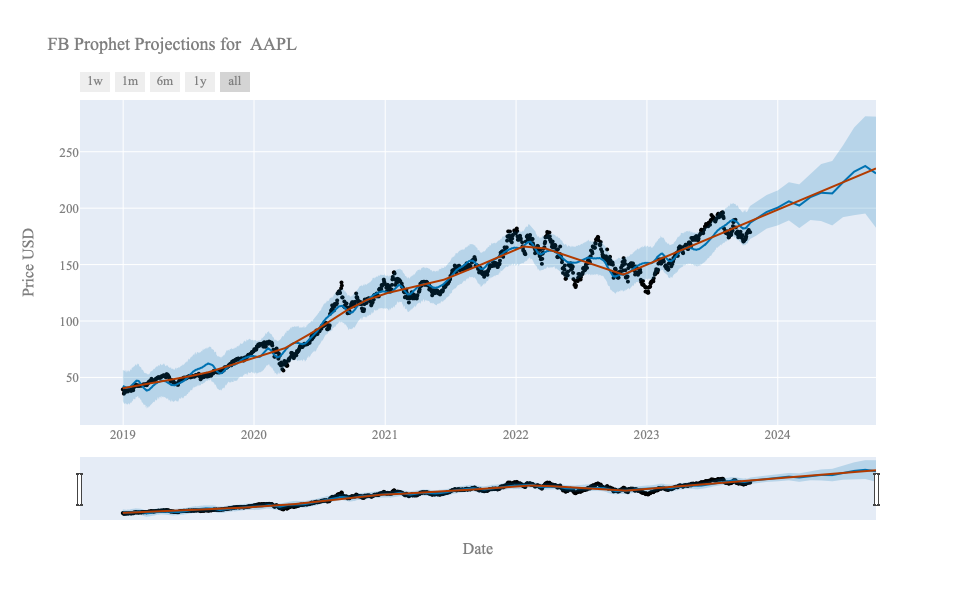

In [352]:
model = Prophet(interval_width=0.95)
model.fit(d2)

forecast = model.make_future_dataframe(periods=12, freq='MS',                              
                                      )
forecast = model.predict(forecast)
fig = plot_plotly(model, forecast, trend=True,  
                  )
fig.update_layout(
        title="FB Prophet Projections for  AAPL",
        xaxis_title="Date",
        yaxis_title="Price USD",
        font=dict(
            family="Times New Roman",
            size=13,
            color="#7f7f7f"
        ),
    
    )
fig.update_traces(showlegend=True)
fig.show()

In [147]:
d3  = d2.rename(columns = {'ds':'Date',
                          'y':'Close'})

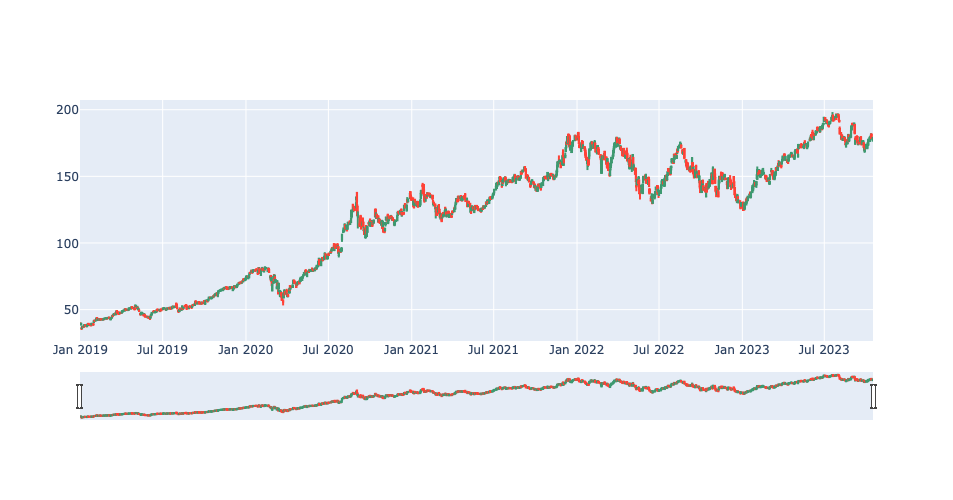

In [309]:
#fig  = go.Figure()
def make_candlestick(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])],

                )

    fig.update_layout(
        autosize=False,
        width = 900,
        height= 500,)

    fig.show()
make_candlestick(d3)

In [149]:
macd, macd_signal, macd_hist = ta.MACD(data['Close'])

In [154]:
macd, macd_signal, macd_hist = ta.MACD(data['Close'])
mcd = pd.DataFrame(columns =  ['MACD', 
                              'MACD_Signal',  'MACD_hist'],
                   )
mcd['MACD'] = macd
mcd['MACD_Signal'] = macd_signal
mcd['MACD_hist']=macd_hist
mcd['Close'] = data['Close']
#mcd = mcd.reset_index()
mcd = mcd.dropna()

In [155]:
mcd

,MACD,MACD_Signal,MACD_hist,Close
Date,,,,
2019-02-19,1.288302,1.368209,-0.079907,42.732498
2019-02-20,1.266138,1.347795,-0.081657,43.007500
2019-02-21,1.215000,1.321236,-0.106236,42.764999
2019-02-22,1.199179,1.296824,-0.097645,43.242500
2019-02-25,1.198246,1.277109,-0.078863,43.557499
...,...,...,...,...
2023-10-10,-0.821506,-1.746583,0.925077,178.389999
2023-10-11,-0.430537,-1.483374,1.052837,179.800003
2023-10-12,-0.046723,-1.196044,1.149321,180.710007


In [156]:
dax =  mcd.copy()

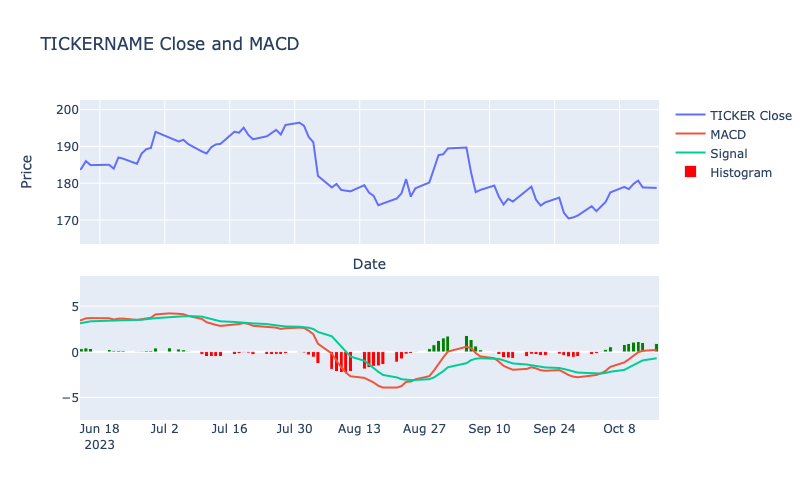

In [210]:
# Create trace for DAX Close
fig = go.Figure()

trace_dax_close = go.Scatter(x=dax.index, y=dax['Close'], name='TICKER Close')
trace_macd = go.Scatter(x=dax.index, y=dax['MACD'], name='MACD',mode='lines')
trace_signal = go.Scatter(x=dax.index, y=dax['MACD_Signal'], name='Signal',mode='lines')

# Create trace for histogram
colors = np.array(['green' if x>0 else 'red' for x in dax['MACD_hist']])
trace_hist = go.Bar(x=dax.index, y=dax['MACD_hist'], name='Histogram',marker=dict(color=colors))
# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add trace to subplot
fig.add_trace(trace_dax_close, row=1, col=1)
fig.add_trace(trace_macd, row=2, col=1)
fig.add_trace(trace_signal, row=2, col=1)
fig.add_trace(trace_hist, row=2, col=1)

# Update layout
fig.update_layout(title='TICKERNAME Close and MACD', xaxis=dict(title='Date'), yaxis=dict(title='Price'))

fig.update_layout(
    autosize=False,
    width = 900,
    height=500,)

# Show the plot
fig.show()

In [159]:
df = data.copy()

In [160]:
# add moving averages to df
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA5'] = df['Close'].rolling(window=5).mean()

In [161]:
df = df.dropna()

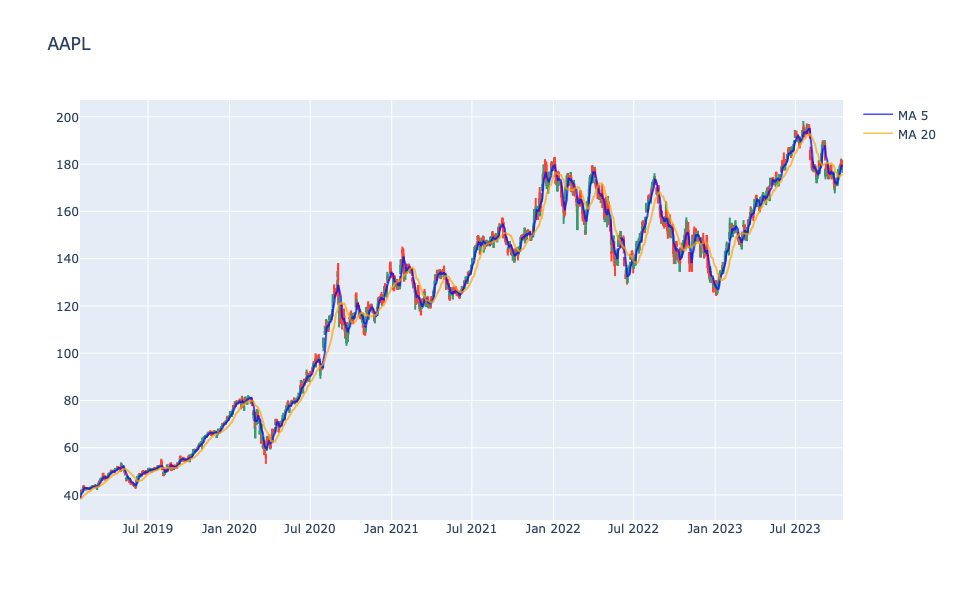

In [248]:
fig =  go.Figure()
fig.add_trace(go.Candlestick(x=df.index,
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             showlegend=False, 
                           ))
#add moving average traces
fig.add_trace(go.Scatter(x=df.index,
                         y=df['MA5'],
                         opacity=0.7,
                         line=dict(color='blue', width=2),
                         name='MA 5', 
                        ))
fig.add_trace(go.Scatter(x=df.index,
                         y=df['MA20'],
                         opacity=0.7,
                         line=dict(color='orange', width=2),
                         name='MA 20', 
                   
                        ))
# hide dates with no values
#fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
# remove rangeslider
fig.update_layout(xaxis_rangeslider_visible=False)
# add chart title
fig.update_layout(
    autosize=False,
    width = 800,
    height=600,)
fig.update_layout(title="AAPL")

In [312]:
s_p = pdr.get_data_yahoo('^GSPC',  start='2018-12-31' )


[*********************100%%**********************]  1 of 1 completed


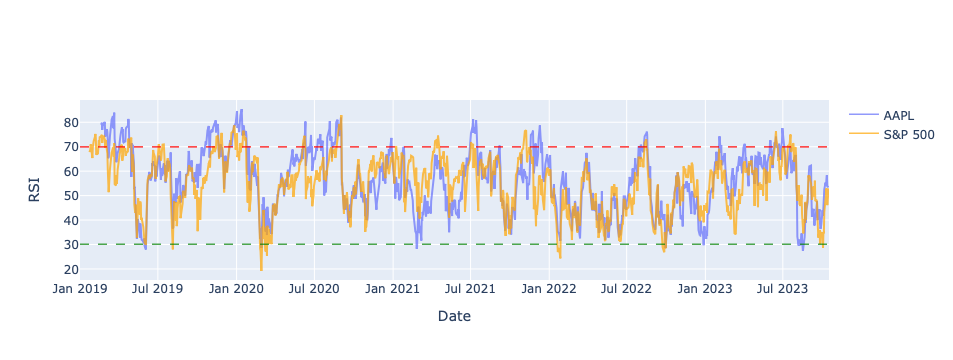

In [319]:
#fig = px.line(x =df.index, y = ta.RSI(df['Close']), title='RSI of TICKER',name="AAPL",  )
fig = go.Figure()

fig.add_trace(go.Scatter(x =df.index,
                         y = ta.RSI(df['Close']),
                         opacity=0.7,
                         #line=dict(color='orange', width=2),
                         name='AAPL', 
                   
                        ))
fig.add_hline(y=70,  line_dash="dash", line_color="red", opacity = .7)
fig.add_hline(y=30,  line_dash="dash", line_color="green", opacity = .7)
fig.update_layout(
        xaxis_title="Date",
        yaxis_title="RSI",
        )

fig.update_layout(
                      yaxis = dict(
                        tickmode='array', #change 1
                        tickvals = [20,30,40,50,60,70,80,], #change 2
                        ticktext = ['20', '30', '40', '50',
                                   '60', '70', '80'], #change 3
                        ))

fig.add_trace(go.Scatter(x=s_p.index,
                         y=ta.RSI(s_p['Close']),
                         opacity=0.7,
                         line=dict(color='orange', width=2),
                         name='S&P 500', 
                   
                        ))

fig.show()


In [320]:
ticker  = 'AAPL'

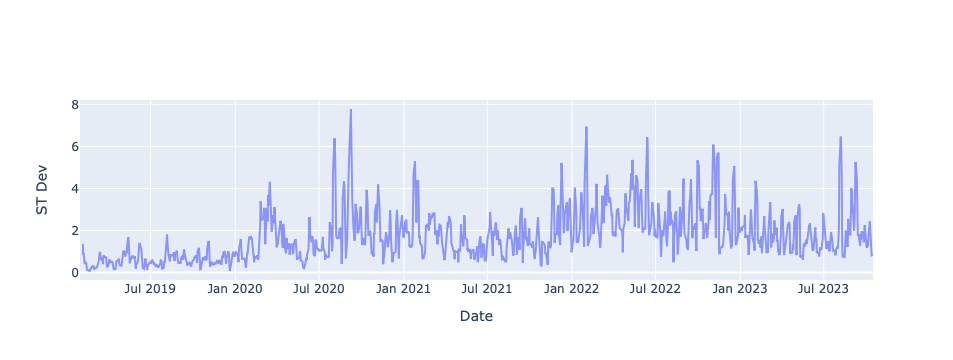

In [324]:
#fig = px.line(x =df.index, y = ta.STDDEV(df['Close']), title='Sandard Dev of TICKER', )
fig = go.Figure()


fig.add_trace(go.Scatter(x =df.index,
                         y = ta.STDDEV(df['Close']),
                         opacity=0.7,
                         #line=dict(color='orange', width=2),
                         name=ticker, 
                   
                        ))



fig.update_layout(
        xaxis_title="Date",
        yaxis_title="ST Dev ",
        )


fig.show()


In [291]:
s_d =  yfin.Ticker('AAPL').info
print("Trailing PEG Ratio:", s_d['trailingPegRatio'])
print("Market Cap:", s_d['marketCap'])
print("EBITDA:", s_d['ebitda'])
print("Current Price: ", s_d['currentPrice'])
print('Trailing PE: ', s_d['trailingPE'])
print('Forward PE: ', s_d['forwardPE'])
print("Total Debt: ", s_d['totalDebt'])
print("Total Revenue:", s_d['totalRevenue'])
print("Debt to Equity:", s_d['debtToEquity'])
print("Total Debt:", s_d['totalDebt'])
print("Total Revenue:",  s_d['totalRevenue']) 
print(" ")
print("Current Price:", s_d['currentPrice'])
print("recommendationKey", s_d['recommendationKey'])
print('Number of Analysts Opinions:', s_d['numberOfAnalystOpinions'])


Trailing PEG Ratio: 2.2867
Market Cap: 2794144137216
EBITDA: 123957002240
Current Price:  178.72
Trailing PE:  30.036976
Forward PE:  27.202435
Total Debt:  109280002048
Total Revenue: 383932989440
Debt to Equity: 181.305
Total Debt: 109280002048
Total Revenue: 383932989440
 
Current Price: 178.72
recommendationKey buy
Number of Analysts Opinions: 36
